# CelebA images

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import torch

sys.path.append("../../")
from experiments.datasets import FFHQStyleGAN2DLoader
from experiments.architectures.image_transforms import create_image_transform, create_image_encoder
from experiments.architectures.vector_transforms import create_vector_transform
from manifold_flow.flows import ManifoldFlow, EncoderManifoldFlow
import plot_settings as ps


In [2]:
ps.setup()

## Helper function to go from torch to numpy conventions

In [3]:
def trf(x):
    return np.clip(np.transpose(x, [1,2,0]) / 256., 0., 1.)

## Samples with lower temperature

In [6]:
def load_model(
    filename,
    latentdim=2,
    outerlayers=20,
    innerlayers=6,
    levels=4,
    splinebins=11,
    splinerange=10.0,
    dropout=0.0,
    actnorm=True,
    batchnorm=False,
    contextfeatures=None,
    linlayers=2,
    linchannelfactor=1,
    lineartransform="lu",
):
    steps_per_level = outerlayers // levels
    outer_transform = create_image_transform(
        3,
        64,
        64,
        levels=levels,
        hidden_channels=100,
        steps_per_level=steps_per_level,
        num_res_blocks=2,
        alpha=0.05,
        num_bits=8,
        preprocessing="glow",
        dropout_prob=dropout,
        multi_scale=True,
        num_bins=splinebins,
        tail_bound=splinerange,
        postprocessing="partial_mlp",
        postprocessing_layers=linlayers,
        postprocessing_channel_factor=linchannelfactor,
        use_actnorm=actnorm,
        use_batchnorm=batchnorm,
    )
    inner_transform = create_vector_transform(
        latentdim,
        innerlayers,
        linear_transform_type=lineartransform,
        base_transform_type="rq-coupling",
        context_features=contextfeatures,
        dropout_probability=dropout,
        tail_bound=splinerange,
        num_bins=splinebins,
        use_batch_norm=batchnorm,
    )
    model = ManifoldFlow(
        data_dim=(3, 64, 64),
        latent_dim=latentdim,
        outer_transform=outer_transform,
        inner_transform=inner_transform,
        apply_context_to_outer=False,
        pie_epsilon=0.1,
        clip_pie=None
    )
        
    model.load_state_dict(
        torch.load("../data/models/{}.pt".format(filename), map_location=torch.device("cpu"))
    )
    _ = model.eval()
    
    return model


mf = load_model("mf_128_celeba_may", outerlayers=28, innerlayers=20, linchannelfactor=2, latentdim=128)


In [9]:
temperatures = [0., 0.5, 0.8, 1.0, 1.2, 1.5, 2.0]
n_each = 5

us = [t * torch.randn(n_each, 128, dtype=torch.float) for t in temperatures]
xs = [mf.sample(u=u, n=n_each, sample_orthogonal=False).detach().numpy() for u in us]


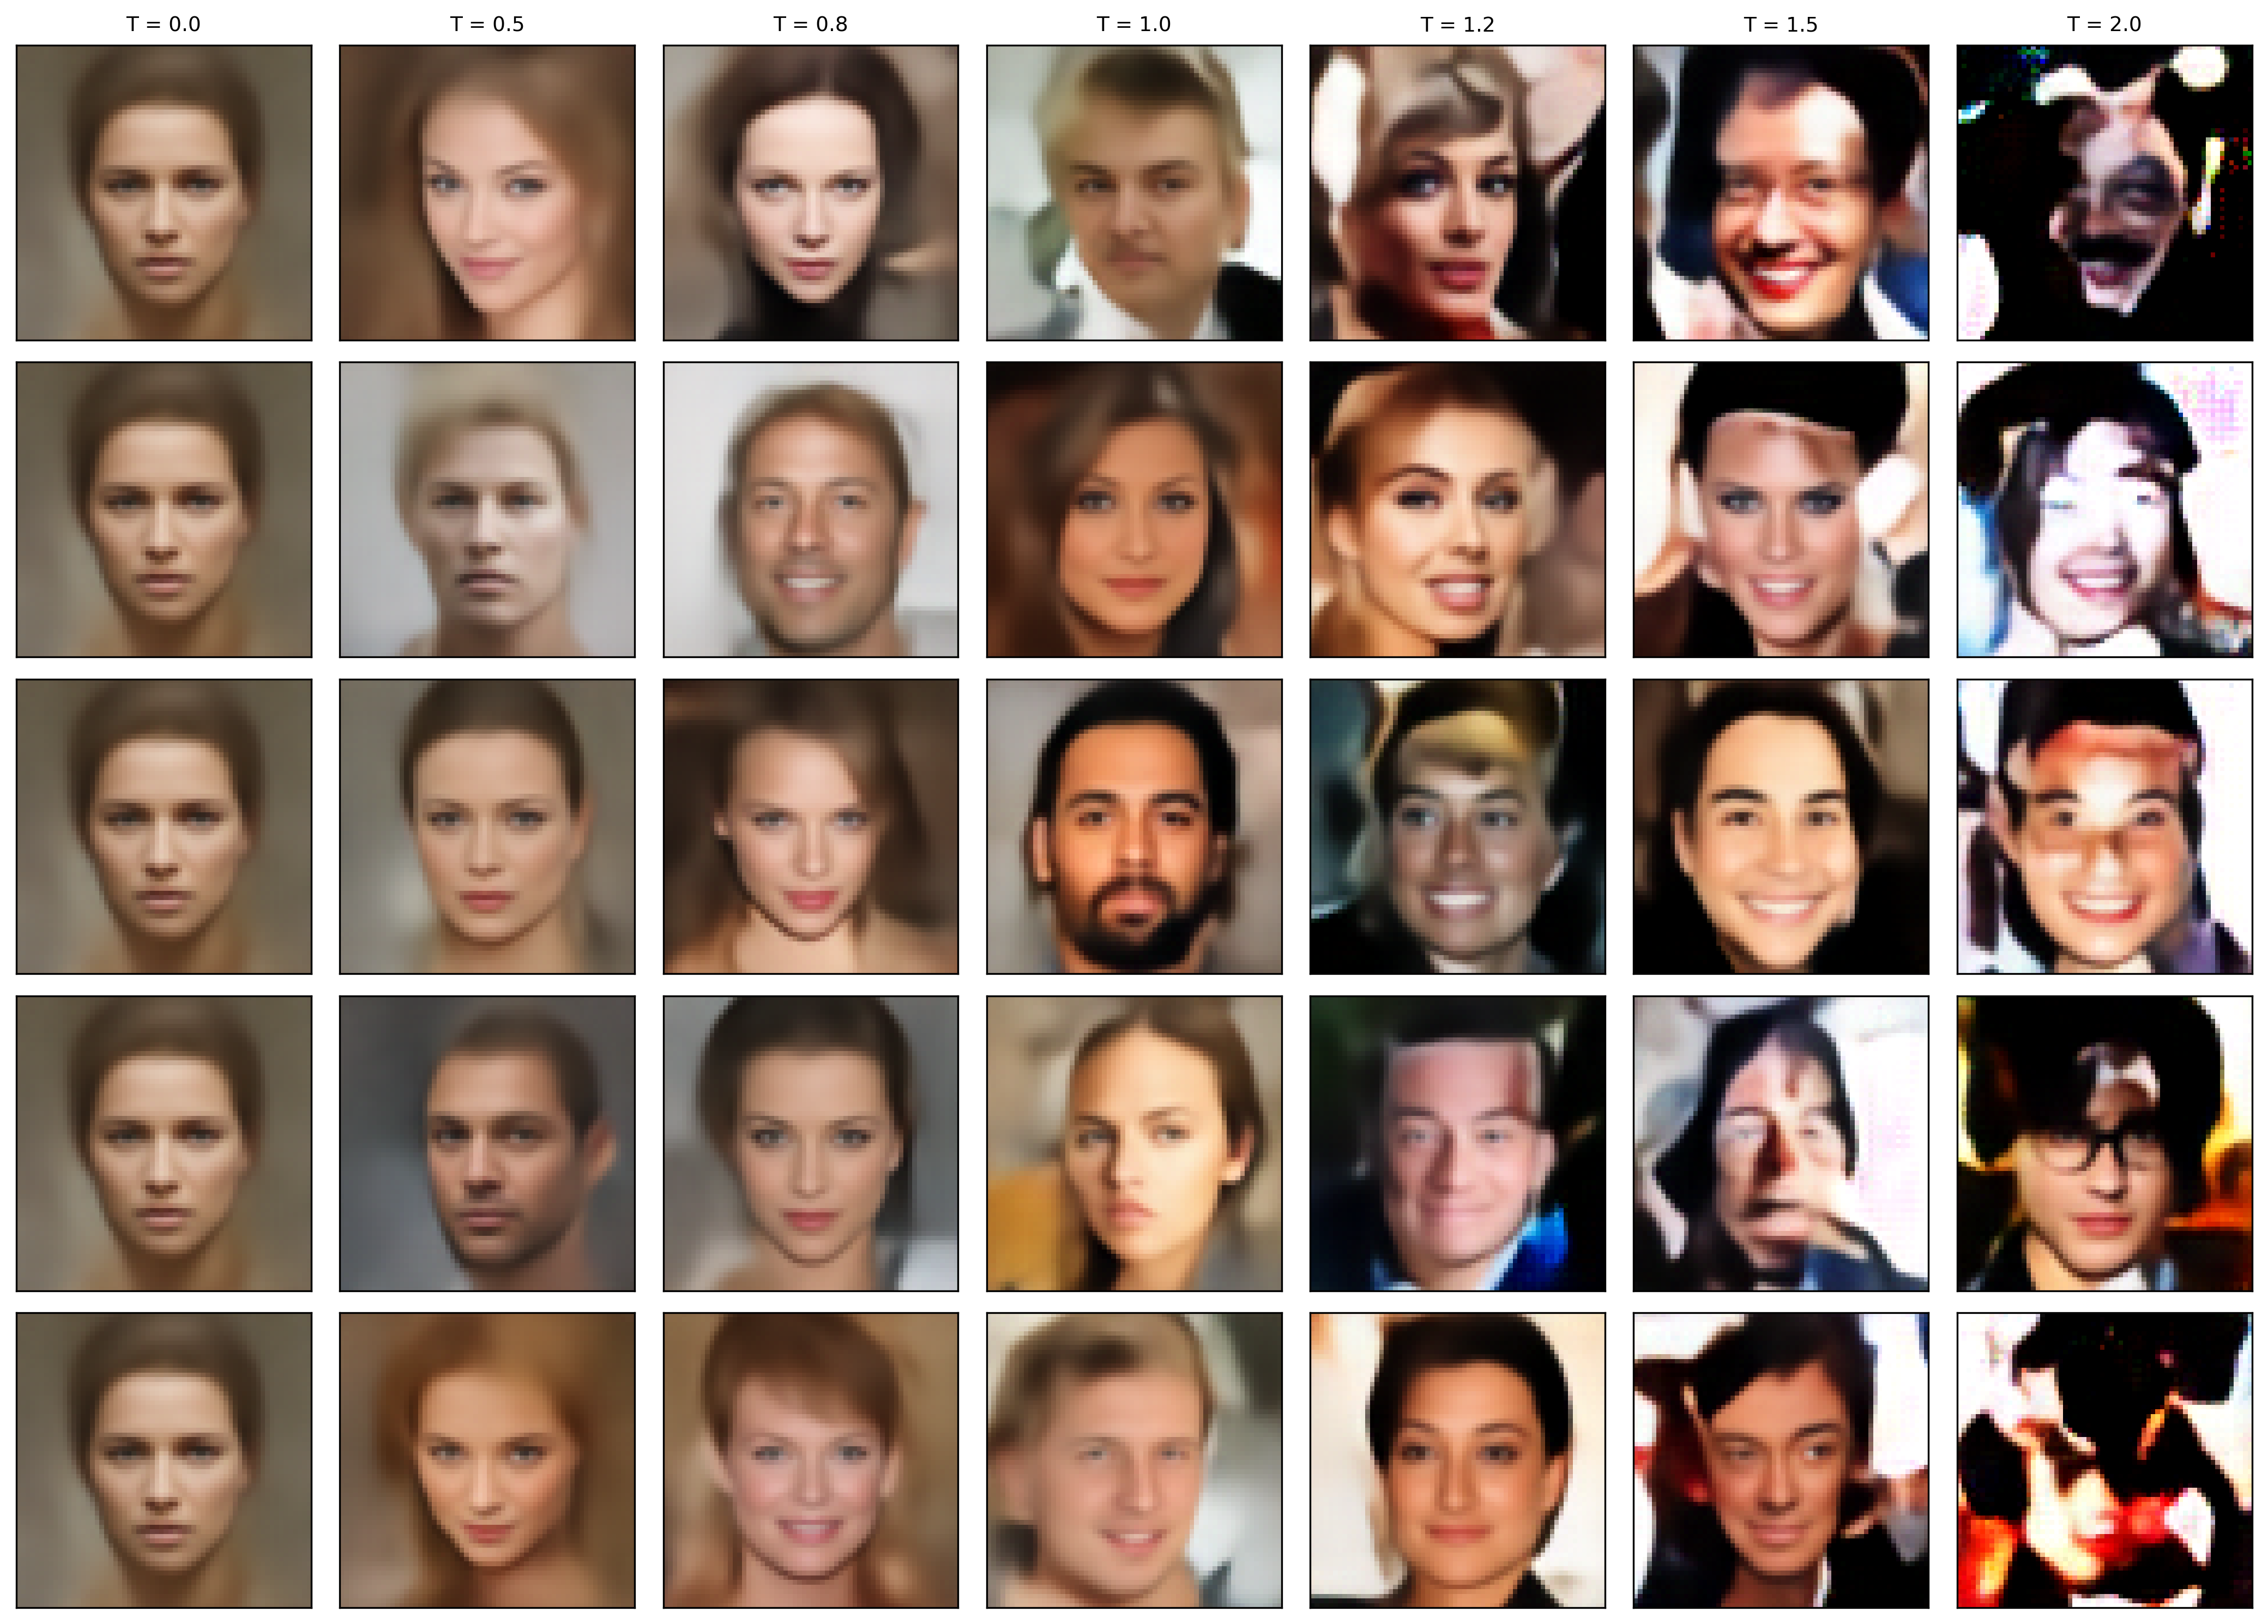

In [10]:
plt.figure(figsize=(len(temperatures)*2.,n_each*2.))
for i, (t, x) in enumerate(zip(temperatures, xs)):
    for j in range(n_each):
        ax = plt.subplot(n_each, len(temperatures), j*len(temperatures) + i + 1)
        plt.imshow(trf(x[j]))
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        
        if j == 0:
            plt.title(f"T = {t}")
        
plt.tight_layout()
plt.show()


## Sample comparison

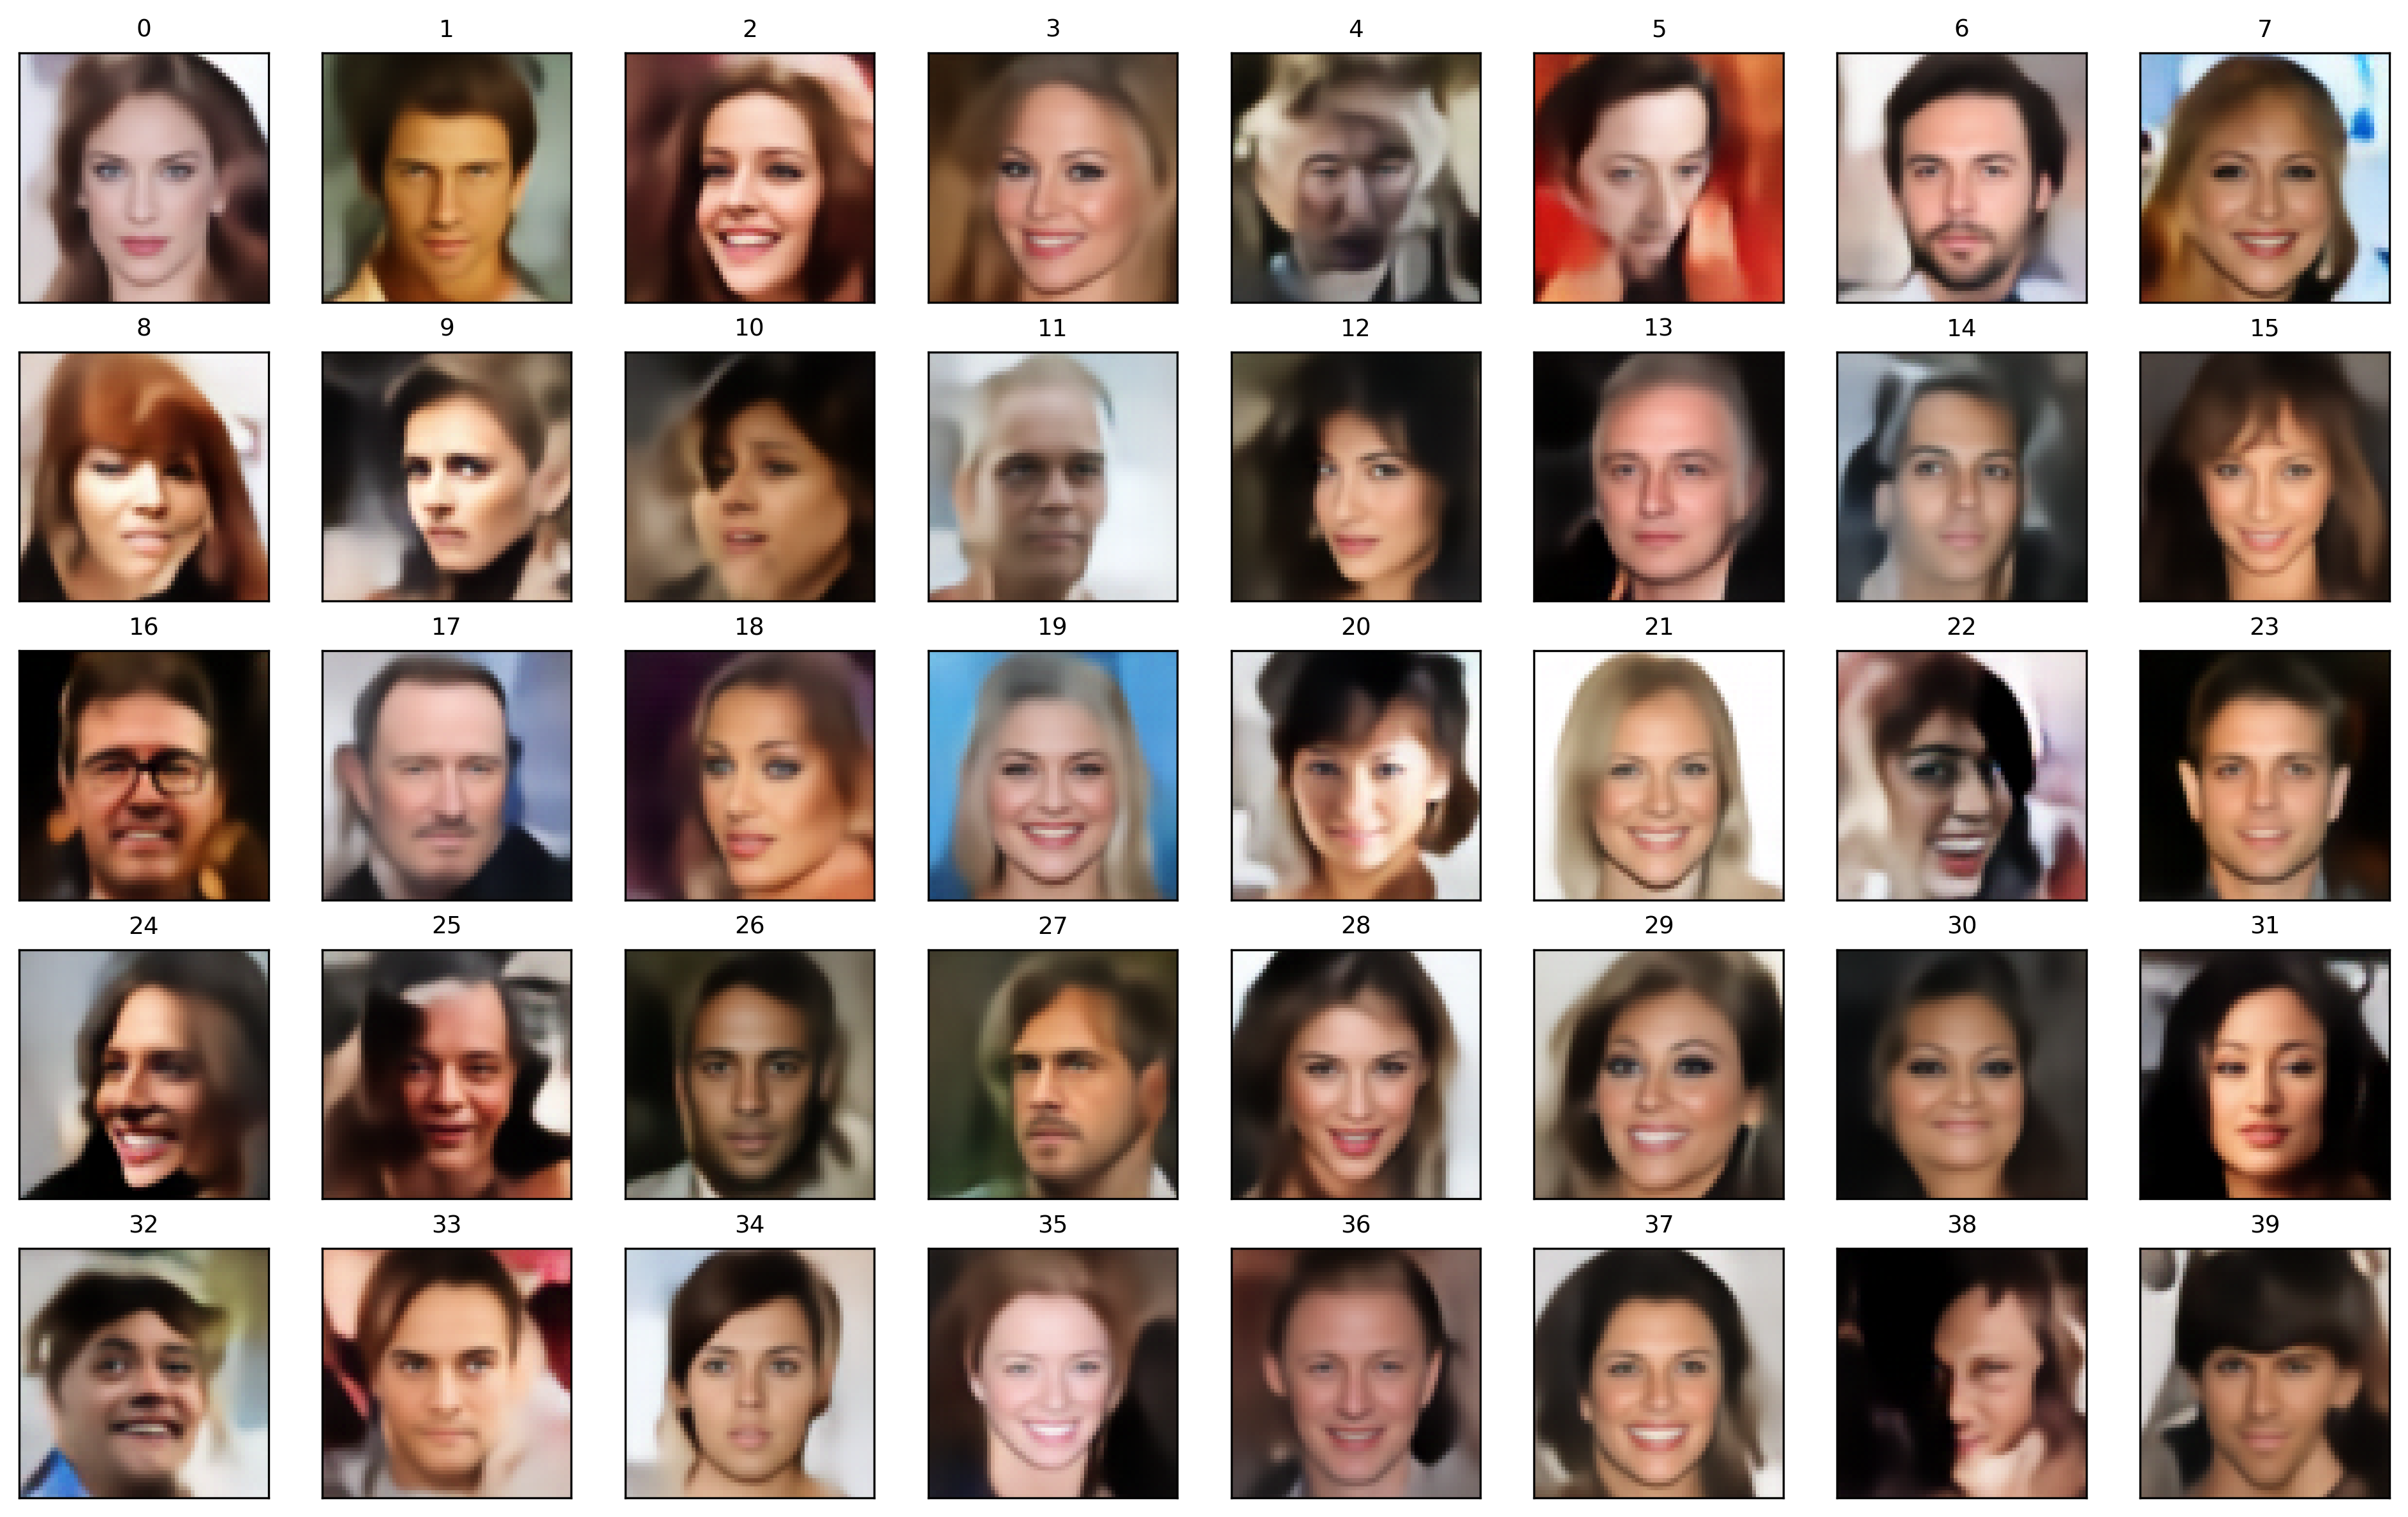

In [5]:
x_ = np.load("../data/results/mf_128_celeba_may_samples.npy")

plt.figure(figsize=(8*2.,5*2.))
for i in range(40):
    ax = plt.subplot(5,8, i+1)
    plt.imshow(trf(x_[i]))
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    plt.title(str(i))
plt.show()


In [5]:
x_test = np.load("../data/samples/celeba/test.npy")[:8]
x_gen_af = np.load("../data/results/flow_512_celeba_april_samples.npy")[[3,7,13,17,21,25,36,38]]
x_gen_pie = np.load("../data/results/pie_512_celeba_april_samples.npy")[[0,1,4,6,12,20,27,34]]
x_gen_mf = np.load("../data/results/mf_512_celeba_april_samples.npy")[[37,25,32,33,19,8,34,13]]
x_gen_emf = np.load("../data/results/emf_512_celeba_april_samples.npy")[[6,32,19,34,1,28,31,16]]


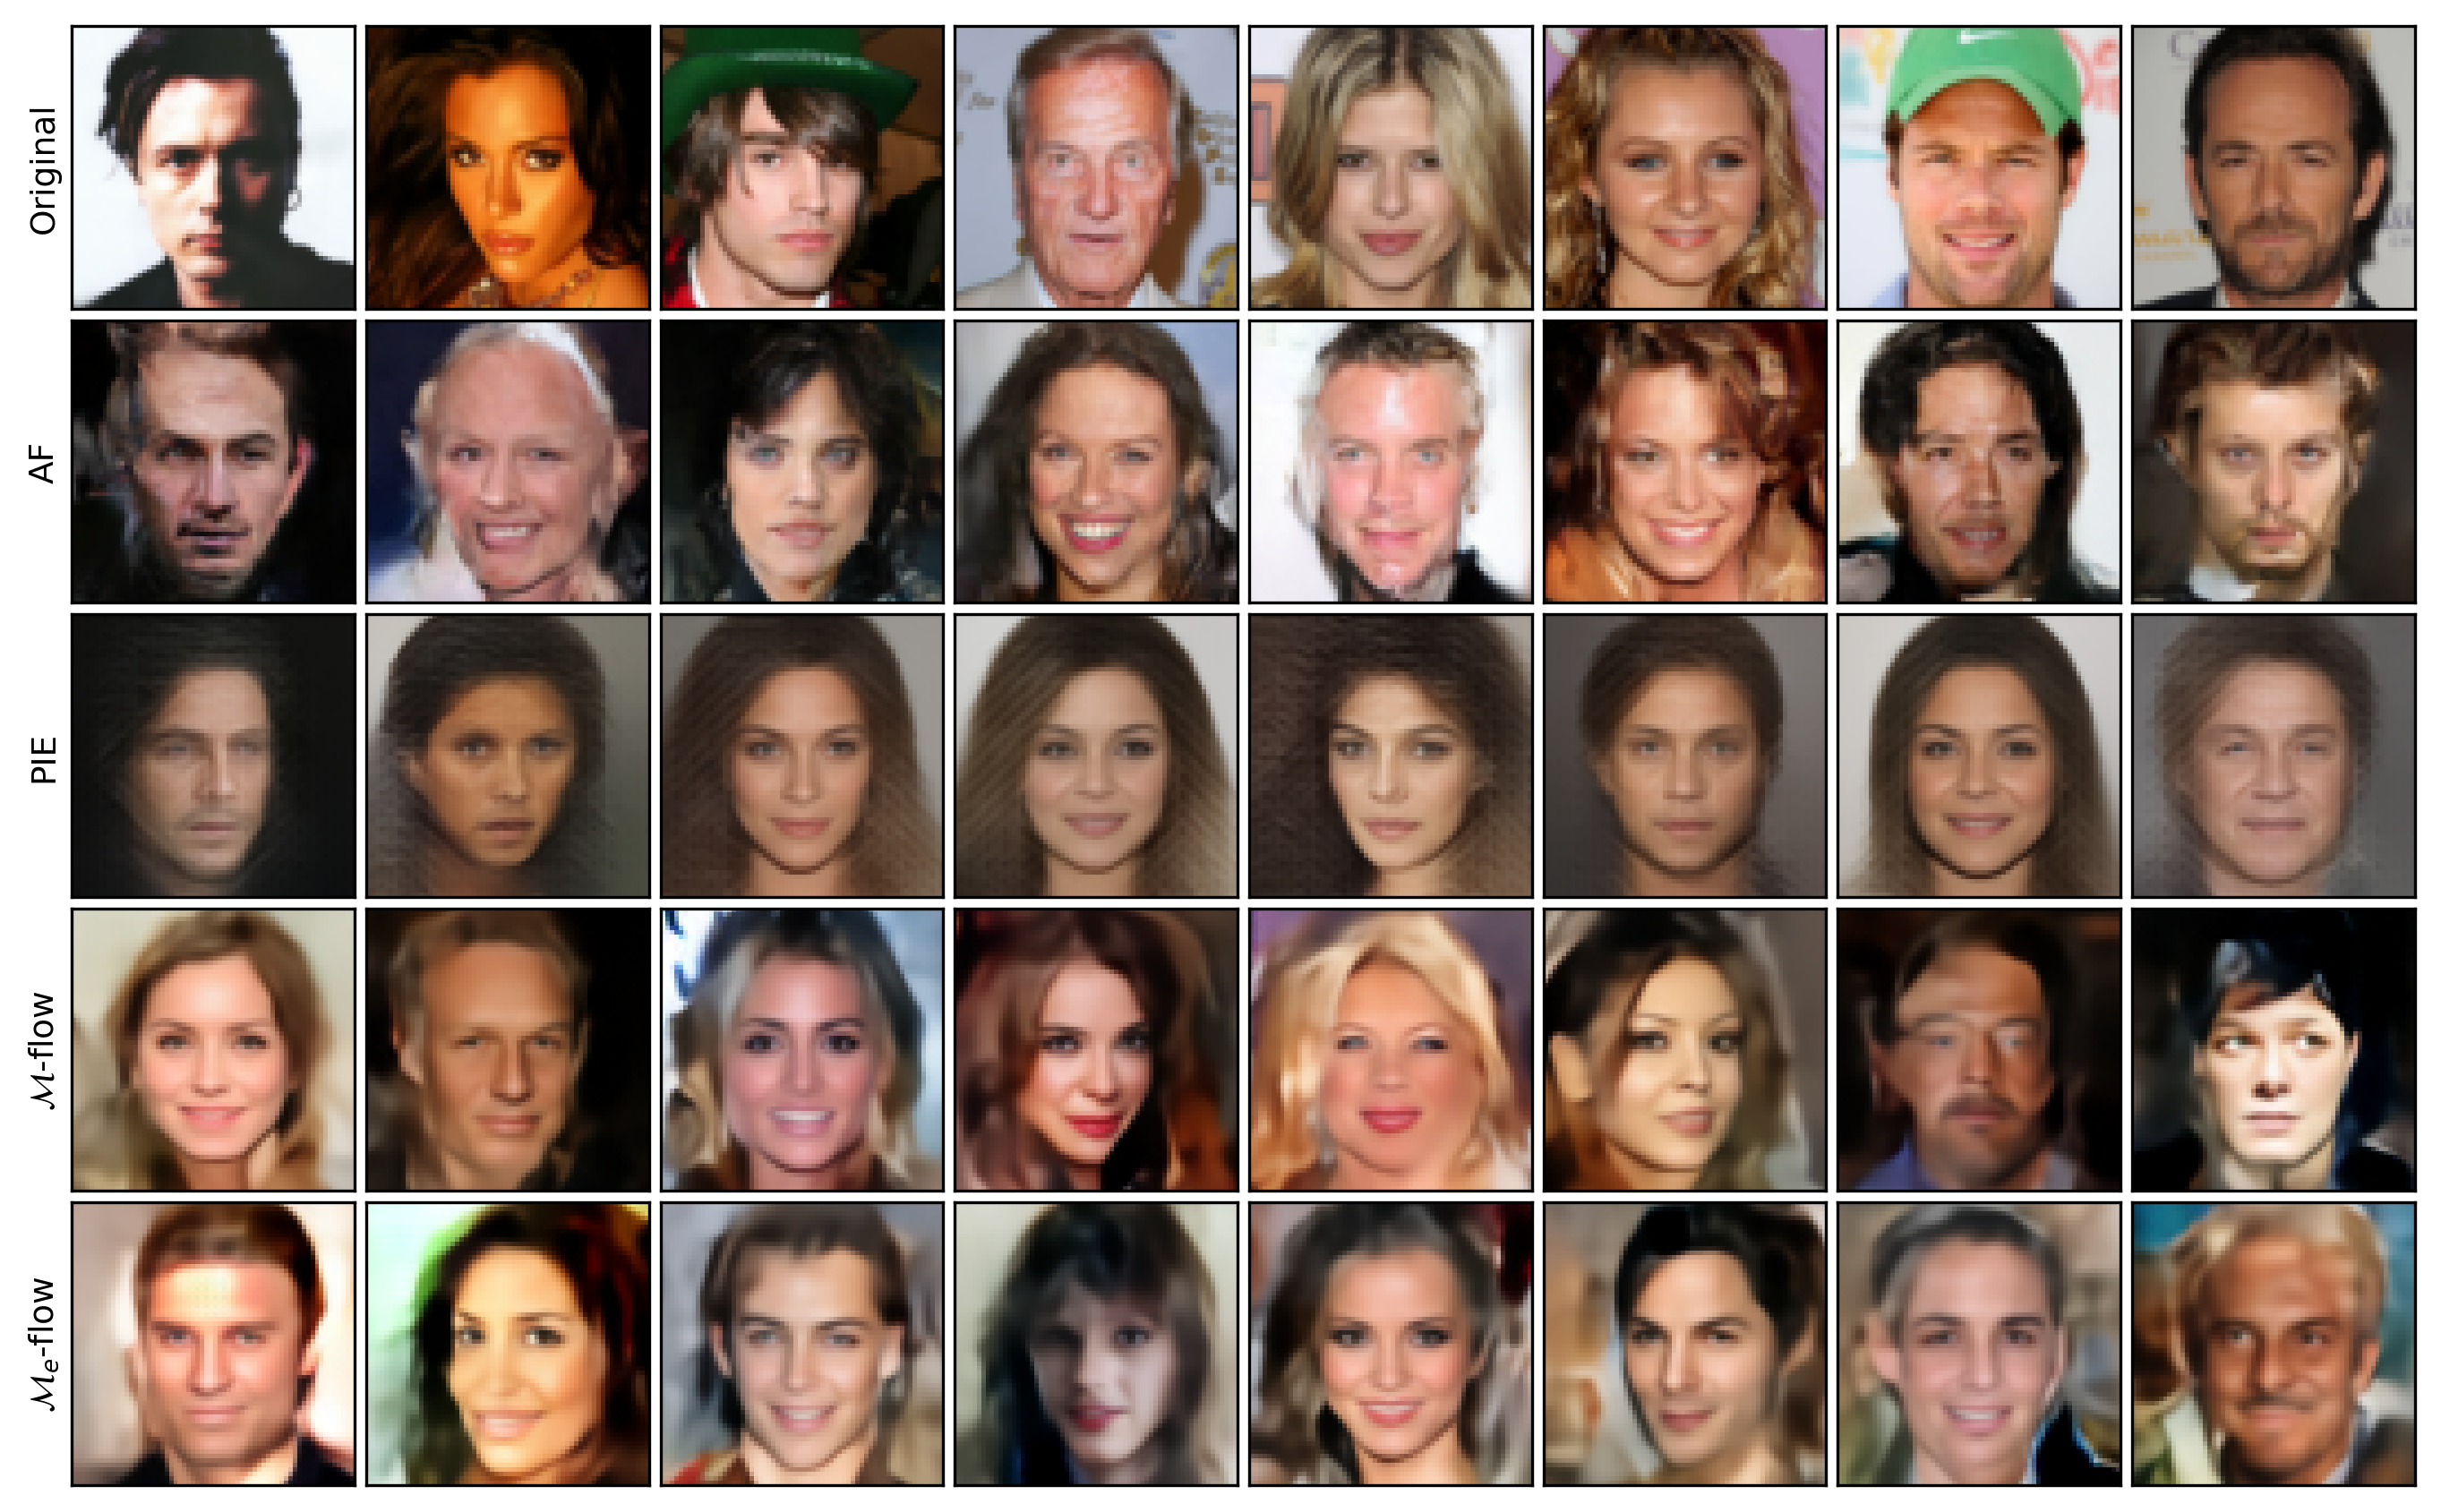

In [7]:
ncols = 8
nrows = 5

xs = [x_test, x_gen_af, x_gen_pie, x_gen_mf, x_gen_emf]
labels = ["Original", "AF", "PIE", r"$\mathcal{M}$-flow", r"$\mathcal{M}_e$-flow"]

fig, gs = ps.grid_width(ncols, nrows, width=ps.TEXTWIDTH, large_margin=0.04, small_margin=0.01, sep=0.007, t_space=False, b_space=False, r_space=False, l_space=True)

for i in range(ncols):
    for j, (x, label) in enumerate(zip(xs, labels)):
        ax = plt.subplot(gs[j*ncols + i])
        plt.imshow(trf(x[i]))
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        if i == 0:
            plt.ylabel(label, labelpad=3)
    
plt.savefig("../figures/celeba_samples.pdf")


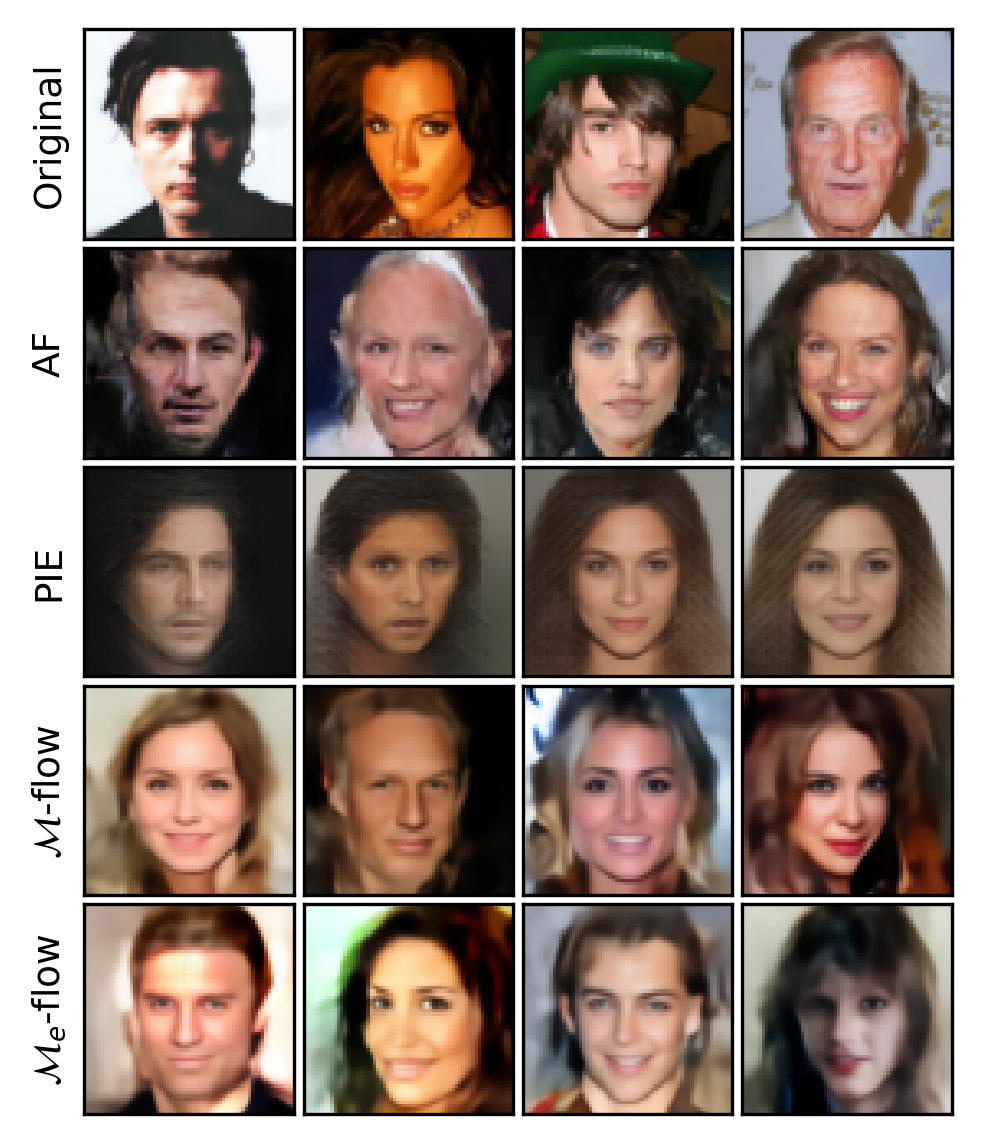

In [11]:
ncols = 4

fig, gs = ps.grid_width(ncols, nrows, width=0.35*ps.TEXTWIDTH, large_margin=0.06, small_margin=0.01, sep=0.007, t_space=False, b_space=False, r_space=False)

for i in range(ncols):
    for j, (x, label) in enumerate(zip(xs, labels)):
        ax = plt.subplot(gs[j*ncols + i])
        plt.imshow(trf(x[i]))
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        if i == 0:
            plt.ylabel(label)
    
plt.savefig("../figures/celeba_samples_small.pdf")


## Test samples and projections to learned manifolds

In [8]:
test_idx = list(range(8, 16))
n_test = len(test_idx)

x_test = np.load("../data/samples/celeba/test.npy")[test_idx]
x_reco_pie = np.load("../data/results/pie_512_celeba_april_model_x_reco_test.npy")[test_idx]
x_reco_mf = np.load("../data/results/mf_512_celeba_april_model_x_reco_test.npy")[test_idx]
x_reco_emf = np.load("../data/results/emf_512_celeba_april_model_x_reco_test.npy")[test_idx]


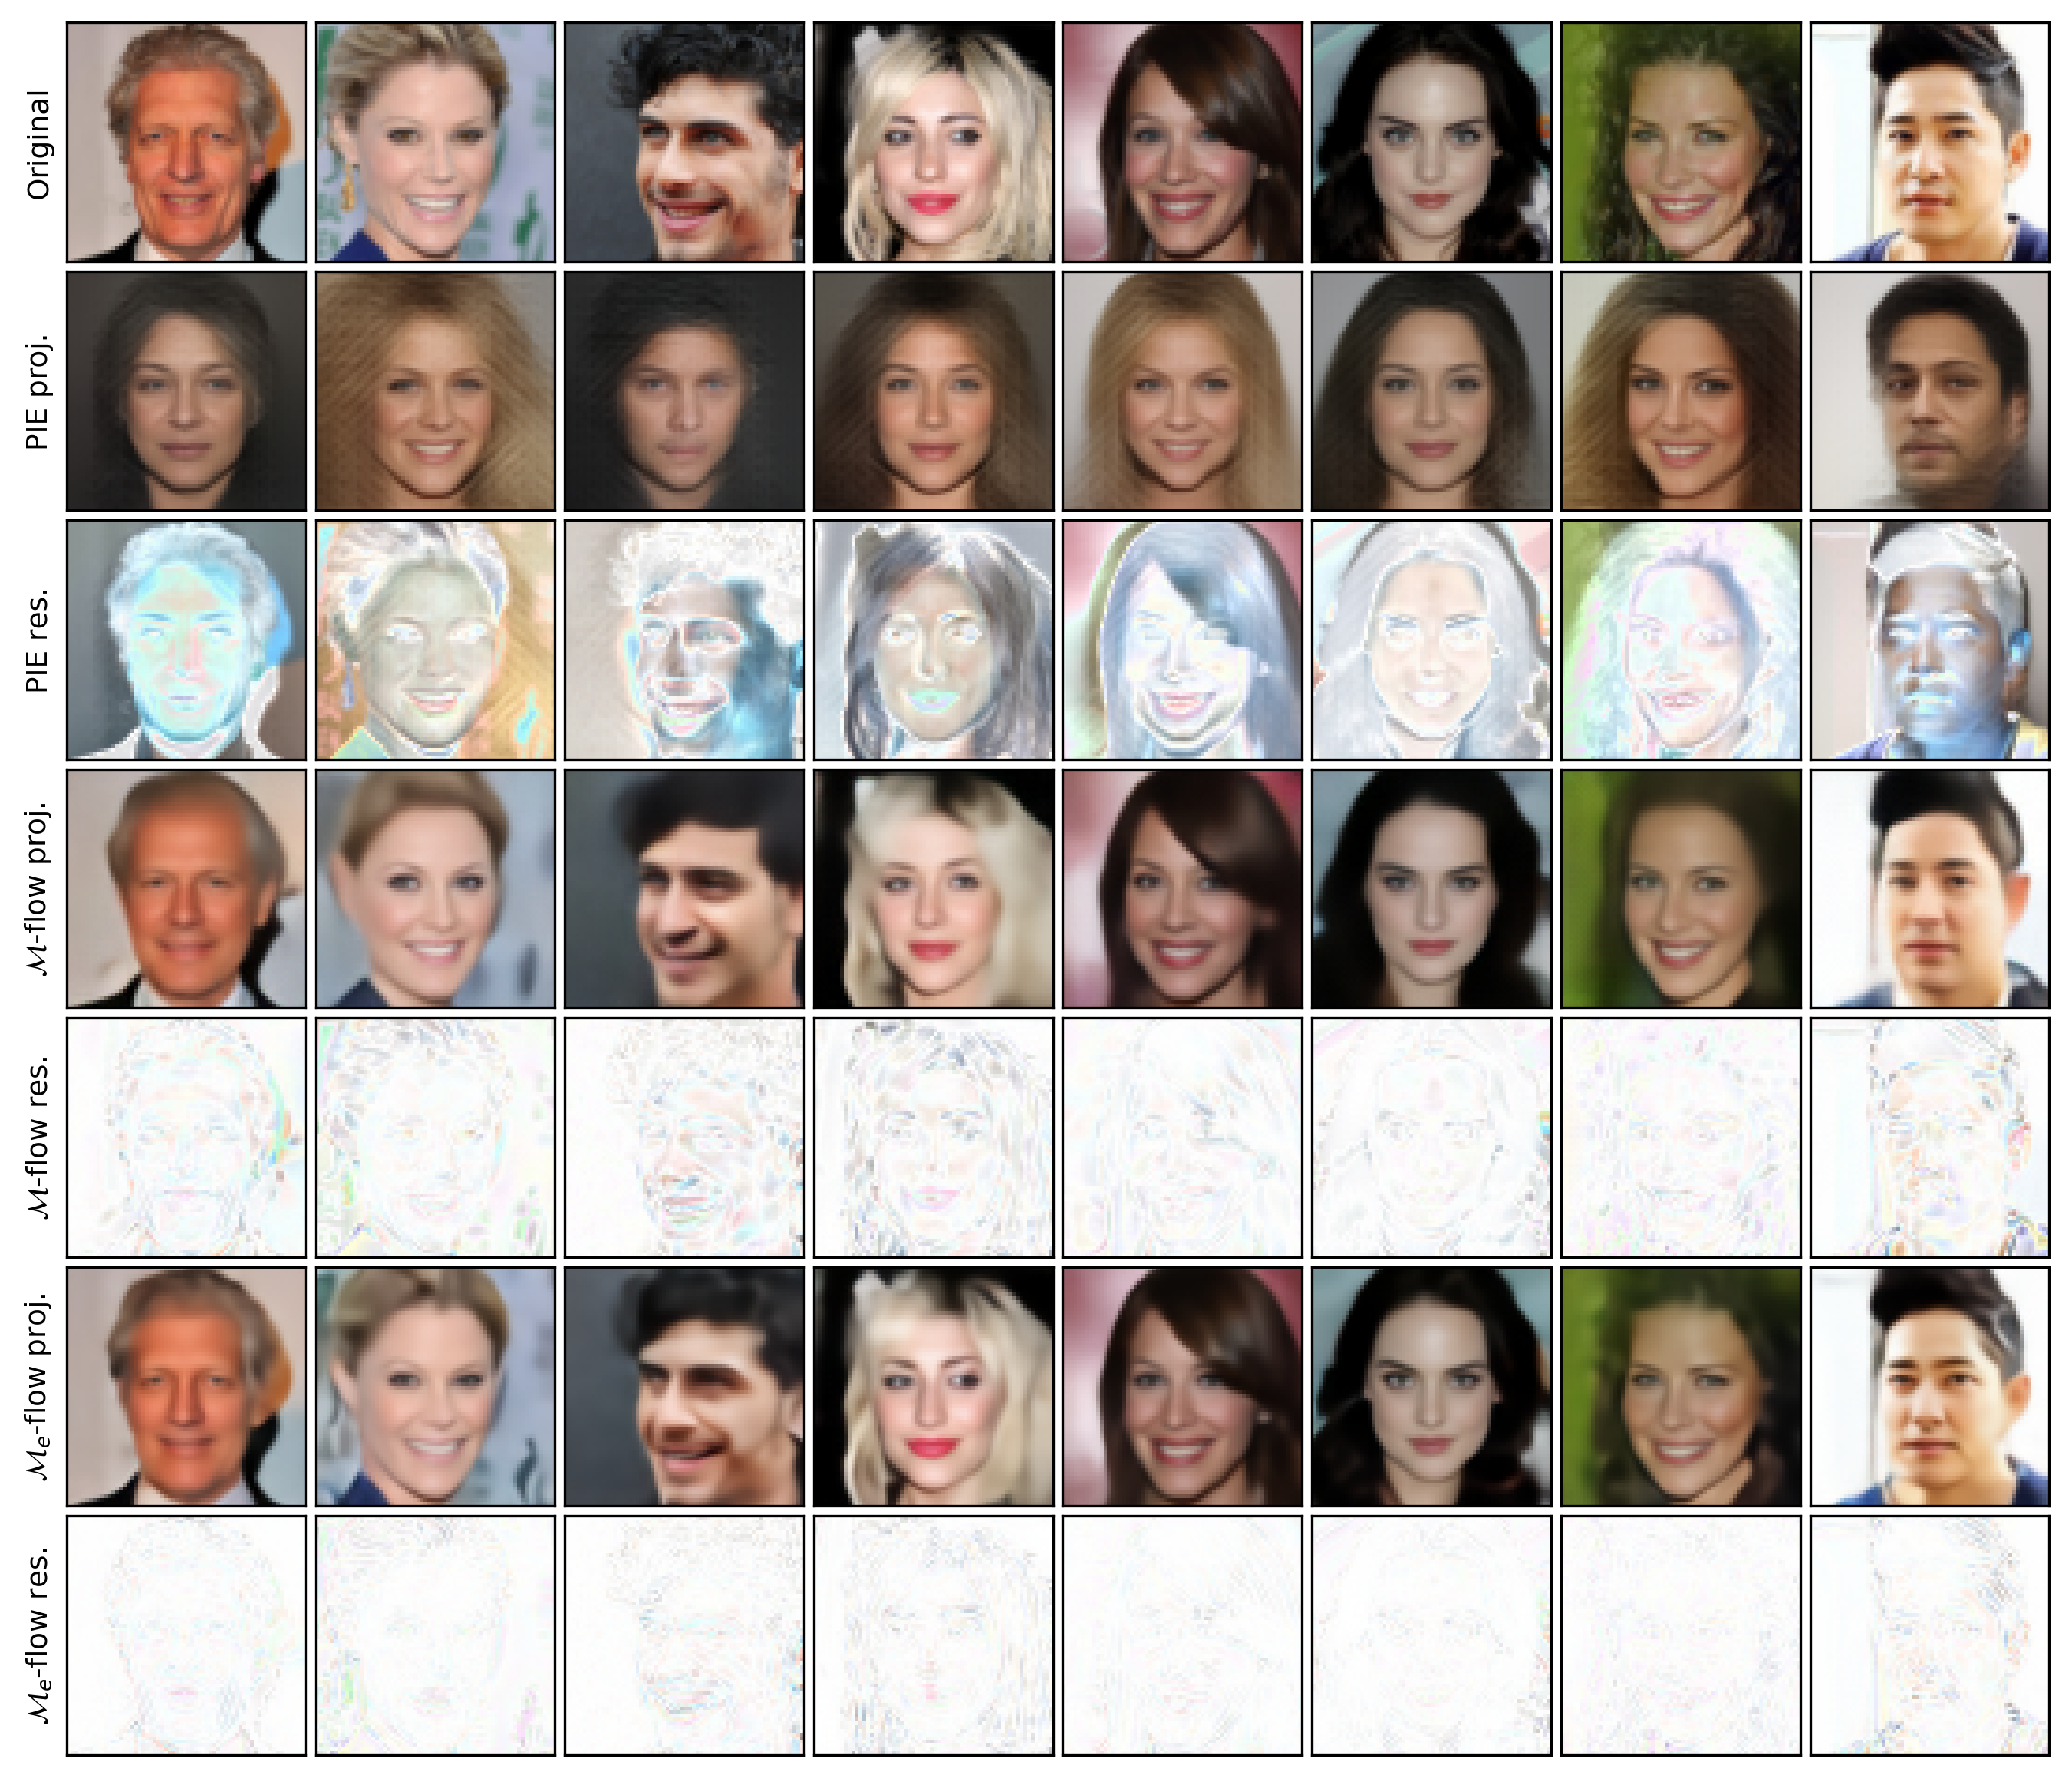

In [9]:
nrows = 7
enhance = 1
labels = ["Original", "PIE proj.", r"PIE res.", "$\mathcal{M}$-flow proj.", r"$\mathcal{M}$-flow res.", "$\mathcal{M}_e$-flow proj.", "$\mathcal{M}_e$-flow res."]

fig, gs = ps.grid_width(n_test, nrows, width=ps.TEXTWIDTH, large_margin=0.04, small_margin=0.01, sep=0.005, t_space=False, b_space=False, r_space=False, l_space=True)

for i in range(n_test):
    xs = [
        trf(x_test[i]),
        trf(x_reco_pie[i]),
        1. - enhance*np.abs(trf(x_reco_pie[i]) - trf(x_test[i])),
        trf(x_reco_mf[i]),
        1. - enhance*np.abs(trf(x_reco_mf[i]) - trf(x_test[i])),
        trf(x_reco_emf[i]),
        1. - enhance*np.abs(trf(x_reco_emf[i]) - trf(x_test[i]))
    ]
    
    for j, (x, label) in enumerate(zip(xs, labels)):
        ax = plt.subplot(gs[j * n_test + i])
        plt.imshow(x)
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        if i == 0:
            plt.ylabel(label)
    
plt.savefig("../figures/celeba_projections.pdf")


In [ ]:
nrows = 5
ncols = 4
enhance = 1
labels = ["Original", "$\mathcal{M}$-flow", r"Residual", "$\mathcal{M}_e$-flow", "Residual"]

fig, gs = ps.grid_width(ncols, nrows, width=0.33 * ps.TEXTWIDTH, large_margin=0.06, small_margin=0.01, sep=0.005, t_space=False, b_space=False, r_space=False, l_space=True)

for i in range(ncols):
    xs = [
        trf(x_test[i]),
        trf(x_reco_mf[i]),
        1. - enhance*np.abs(trf(x_reco_mf[i]) - trf(x_test[i])),
        trf(x_reco_emf[i]),
        1. - enhance*np.abs(trf(x_reco_emf[i]) - trf(x_test[i]))
    ]
    
    for j, (x, label) in enumerate(zip(xs, labels)):
        ax = plt.subplot(gs[j * ncols + i])
        plt.imshow(x)
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        if i == 0:
            plt.ylabel(label)
    
plt.savefig("../figures/celeba_projections_small.pdf")
